In [4]:
import pandas as pd
import numpy as np
import os

results_dir = "[3] Test Input"

input_dir = "[4] TT Input"

""" output_dir = "Top Tester Results"

os.makedirs(output_dir, exist_ok=True) """

' output_dir = "Top Tester Results"\n\nos.makedirs(output_dir, exist_ok=True) '

In [5]:
# ...existing code...

dfs = {}
dfs_fit = {}

files = [file for file in os.listdir(results_dir) if file.endswith(('.xlsx', '.xls'))]

for file in files:
    file_path = os.path.join(results_dir, file)
    key = file.split('.')[0]
    if key.endswith('_FIT'):
        dfs_fit[key] = pd.read_excel(file_path)
    else:
        dfs[key] = pd.read_excel(file_path)

print("Raw dataframes:", list(dfs.keys()))
print("Fit dataframes:", list(dfs_fit.keys()))
print(f"Found {len(dfs)} raw and {len(dfs_fit)} fit dataframes in {results_dir}.")
if len(dfs) != len(dfs_fit):
    print("Warning: Mismatch between raw and fit dataframes!")

experiments = dfs[list(dfs.keys())[1]]['experiment'].unique().tolist()
variables = dfs[list(dfs.keys())[1]].columns[4:].tolist()
parameters = dfs[list(dfs.keys())[1]].columns[:4].tolist()
print(f"\nFound {len(experiments)} experiments, {len(variables)} variables and {len(parameters)} parameters:")
print(" "+', '.join(experiments))
print(" "+', '.join(variables))
print(" "+', '.join(parameters))

Raw dataframes: ['RESULTS', 'RESULTS_ASR_control', 'RESULTS_MERGED', 'RESULTS_MERGED_ASR_control', 'RESULTS_MERGED_DATE', 'RESULTS_MERGED_DATE_ASR_control', 'RESULTS_MERGED_EXP', 'RESULTS_MT10', 'RESULTS_MT10_ASR_control', 'RESULTS_MTT_MERGED', 'RESULTS_MTT_MERGED_ASR_control', 'RESULTS_MTT_MERGED_DATE', 'RESULTS_MTT_MERGED_DATE_ASR_control', 'RESULTS_MTT_MERGED_EXP', 'RESULTS_T10', 'RESULTS_T10_ASR_control', 'RESULTS_TT_MERGED', 'RESULTS_TT_MERGED_ASR_control', 'RESULTS_TT_MERGED_DATE', 'RESULTS_TT_MERGED_DATE_ASR_control', 'RESULTS_TT_MERGED_EXP', 'SegmentOrder', 'SegmentOrder_ASR_control']
Fit dataframes: []
Found 23 raw and 0 fit dataframes in [3] Test Input.

Found 1 experiments, 9 variables and 4 parameters:
 ASR_control
 reactionTime, peakTime, difference, peakValue, PTPA, PTTA, RMS, tau, AUC
 animal, sex, date, experiment


In [6]:
# ...existing code...
before = len(dfs)
files = [file for file in os.listdir(input_dir) if file.endswith(('.xlsx', '.xls'))]

for file in files:
    file_path = os.path.join(input_dir, file)
    key = file.split('.')[0]
    dfs[key] = pd.read_excel(file_path)
    print(f"Loaded {file} into dataframe with key '{key}'.")

print("All dataframes:", list(dfs.keys()))

experiments = dfs[list(dfs.keys())[1]]['experiment'].unique().tolist()
variables = dfs[list(dfs.keys())[1]].columns[4:].tolist()
parameters = dfs[list(dfs.keys())[1]].columns[:4].tolist()
print(f"\nFound {len(experiments)} experiments, {len(variables)} variables and {len(parameters)} parameters:")
print(" "+', '.join(experiments))
print(" "+', '.join(variables))
print(" "+', '.join(parameters))

Loaded C10.xlsx into dataframe with key 'C10'.
Loaded C20.xlsx into dataframe with key 'C20'.
Loaded C30.xlsx into dataframe with key 'C30'.
Loaded C40.xlsx into dataframe with key 'C40'.
Loaded C50.xlsx into dataframe with key 'C50'.
Loaded CM10.xlsx into dataframe with key 'CM10'.
Loaded CM20.xlsx into dataframe with key 'CM20'.
Loaded CM30.xlsx into dataframe with key 'CM30'.
Loaded CM40.xlsx into dataframe with key 'CM40'.
Loaded CM50.xlsx into dataframe with key 'CM50'.
Loaded RESULTS_MT10.xlsx into dataframe with key 'RESULTS_MT10'.
Loaded RESULTS_MT20.xlsx into dataframe with key 'RESULTS_MT20'.
Loaded RESULTS_MT30.xlsx into dataframe with key 'RESULTS_MT30'.
Loaded RESULTS_MT40.xlsx into dataframe with key 'RESULTS_MT40'.
Loaded RESULTS_MT50.xlsx into dataframe with key 'RESULTS_MT50'.
Loaded RESULTS_T10.xlsx into dataframe with key 'RESULTS_T10'.
Loaded RESULTS_T20.xlsx into dataframe with key 'RESULTS_T20'.
Loaded RESULTS_T30.xlsx into dataframe with key 'RESULTS_T30'.
Loaded

In [7]:
# ...existing code...

from scipy.stats import mannwhitneyu

def compare_dataframes(df1, df2, parameters, variables):
    results = []
    # Get all unique parameter combinations in df1
    param_combos = df1[parameters].drop_duplicates()
    for _, combo in param_combos.iterrows():
        # Filter both dataframes for this parameter combo
        mask1 = (df1[parameters] == combo.values).all(axis=1)
        mask2 = (df2[parameters] == combo.values).all(axis=1)
        if mask1.sum() == 0 or mask2.sum() == 0:
            continue  # Skip if combo not present in both
        for var in variables:
            data1 = df1.loc[mask1, var].dropna()
            data2 = df2.loc[mask2, var].dropna()
            if len(data1) < 2 or len(data2) < 2:
                continue  # Need at least 2 samples for Mann-Whitney
            stat, p = mannwhitneyu(data1, data2, alternative='two-sided')
            results.append({
                **dict(zip(parameters, combo.values)),
                'variable': var,
                'statistic': stat,
                'p_value': p,
                'n_df1': len(data1),
                'n_df2': len(data2)
            })
    return pd.DataFrame(results)

In [8]:
# ...existing code...

import ast

def flatten_column(col):
    # Flattens a column of lists, stringified lists, or scalars into a single list of numbers
    out = []
    for item in col.dropna():
        if isinstance(item, list):
            out.extend(item)
        elif isinstance(item, str):
            try:
                parsed = ast.literal_eval(item)
                if isinstance(parsed, list):
                    out.extend(parsed)
                elif isinstance(parsed, (int, float, np.integer, np.floating)):
                    out.append(parsed)
            except Exception:
                continue  # Ignore strings that can't be parsed
        elif isinstance(item, (int, float, np.integer, np.floating)):
            out.append(item)
        # Ignore non-numeric, non-list
    return pd.Series(out)

# ...existing code...

def compare_general_trends(df1, df2, variables):
    summary = []
    for var in variables:
        flat1 = flatten_column(df1[var])
        flat2 = flatten_column(df2[var])
        if len(flat1) > 0 and len(flat2) > 0:
            mean_diff = flat1.mean() - flat2.mean()
            stats = {
                'mean_difference': mean_diff,
                'df1_median': flat1.median(),
                'df1_std': flat1.std(),
                'df1_n': flat1.count(),
                'df2_median': flat2.median(),
                'df2_std': flat2.std(),
                'df2_n': flat2.count(),
            }
            summary.append({
                'variable': var,
                **stats
            })
        else:
            summary.append({
                'variable': var,
                'mean_difference': 'no data',
                'df1_median': 'no data',
                'df1_std': 'no data',
                'df1_n': len(flat1),
                'df2_median': 'no data',
                'df2_std': 'no data',
                'df2_n': len(flat2),
            })
    return pd.DataFrame(summary)


from scipy.stats import mannwhitneyu

def test_general_trend_significance(df1, df2, variables):
    results = []
    for var in variables:
        flat1 = flatten_column(df1[var])
        flat2 = flatten_column(df2[var])
        if len(flat1) > 1 and len(flat2) > 1:
            stat, p = mannwhitneyu(flat1, flat2, alternative='two-sided')
            results.append({
                'variable': var,
                'n_df1': len(flat1),
                'n_df2': len(flat2),
                'statistic': stat,
                'p_value': p
            })
        else:
            results.append({
                'variable': var,
                'n_df1': len(flat1),
                'n_df2': len(flat2),
                'statistic': 'no data',
                'p_value': 'no data'
            })
    return pd.DataFrame(results)

# ...existing code...

In [9]:
# ...existing code...

def compare_general_trends_by_sex(df1, df2, variables):
    summary = []
    sexes = sorted(set(df1['sex'].dropna().unique()).union(df2['sex'].dropna().unique()))
    for sex in sexes:
        df1_sex = df1[df1['sex'] == sex]
        df2_sex = df2[df2['sex'] == sex]
        for var in variables:
            flat1 = flatten_column(df1_sex[var]) if var in df1_sex else pd.Series([])
            flat2 = flatten_column(df2_sex[var]) if var in df2_sex else pd.Series([])
            if len(flat1) > 0 and len(flat2) > 0:
                mean_diff = flat1.mean() - flat2.mean()
                stats = {
                    'sex': sex,
                    'variable': var,
                    'mean_difference': mean_diff,
                    'df1_median': flat1.median(),
                    'df1_std': flat1.std(),
                    'df1_n': flat1.count(),
                    'df2_median': flat2.median(),
                    'df2_std': flat2.std(),
                    'df2_n': flat2.count(),
                }
                summary.append(stats)
            else:
                summary.append({
                    'sex': sex,
                    'variable': var,
                    'mean_difference': 'no data',
                    'df1_median': 'no data',
                    'df1_std': 'no data',
                    'df1_n': len(flat1),
                    'df2_median': 'no data',
                    'df2_std': 'no data',
                    'df2_n': len(flat2),
                })
    return pd.DataFrame(summary)

def test_general_trend_significance_by_sex(df1, df2, variables):
    results = []
    sexes = sorted(set(df1['sex'].dropna().unique()).union(df2['sex'].dropna().unique()))
    for sex in sexes:
        df1_sex = df1[df1['sex'] == sex]
        df2_sex = df2[df2['sex'] == sex]
        for var in variables:
            flat1 = flatten_column(df1_sex[var]) if var in df1_sex else pd.Series([])
            flat2 = flatten_column(df2_sex[var]) if var in df2_sex else pd.Series([])
            if len(flat1) > 1 and len(flat2) > 1:
                stat, p = mannwhitneyu(flat1, flat2, alternative='two-sided')
                results.append({
                    'sex': sex,
                    'variable': var,
                    'n_df1': len(flat1),
                    'n_df2': len(flat2),
                    'statistic': stat,
                    'p_value': p
                })
            else:
                results.append({
                    'sex': sex,
                    'variable': var,
                    'n_df1': len(flat1),
                    'n_df2': len(flat2),
                    'statistic': 'no data',
                    'p_value': 'no data'
                })
    return pd.DataFrame(results)


In [10]:
df1 = dfs['RESULTS_T10']
df2 = dfs['RESULTS_MT10']

In [11]:
result_df = compare_dataframes(df1, df2, parameters, variables)
print(result_df)

Empty DataFrame
Columns: []
Index: []


In [12]:
trend_df = compare_general_trends(df1, df2, variables)
print(trend_df)

       variable  mean_difference  df1_median      df1_std  df1_n  df2_median  \
0  reactionTime        -0.366578       10.00     1.967547    163      10.000   
1      peakTime         0.083326       30.00     6.485799    163      30.000   
2    difference         0.449904       20.00     6.788637    163      20.000   
3     peakValue        19.891307      138.00    64.276660    163     113.000   
4          PTPA        19.255717      138.50    63.224637    163     113.515   
5          PTTA        17.529806      125.76    58.638945    163      99.940   
6           RMS         6.583474       48.80    24.783917    163      43.845   
7           tau       -11.413057      127.32    52.755159    163     141.065   
8           AUC       972.014815    12118.11  6196.587632    163   10617.225   

       df2_std  df2_n  
0     1.972935   1364  
1     4.720723   1364  
2     5.170536   1364  
3    60.264737   1364  
4    59.679430   1364  
5    55.218484   1364  
6    24.364782   1364  
7    49

In [13]:
print("Top 10:")
trend_df = compare_general_trends(dfs['RESULTS_T10'], dfs['RESULTS_MT10'], variables)
print(trend_df)
sig_df = test_general_trend_significance(dfs['RESULTS_T10'], dfs['RESULTS_MT10'], variables)
print(sig_df)

print("Top 20:")
trend_df = compare_general_trends(dfs['RESULTS_T20'], dfs['RESULTS_MT20'], variables)
print(trend_df)
sig_df = test_general_trend_significance(dfs['RESULTS_T20'], dfs['RESULTS_MT20'], variables)
print(sig_df)

print("Top 30:")
trend_df = compare_general_trends(dfs['RESULTS_T30'], dfs['RESULTS_MT30'], variables)
print(trend_df)
sig_df = test_general_trend_significance(dfs['RESULTS_T30'], dfs['RESULTS_MT30'], variables)
print(sig_df)

print("Top 40:")
trend_df = compare_general_trends(dfs['RESULTS_T40'], dfs['RESULTS_MT40'], variables)
print(trend_df)
sig_df = test_general_trend_significance(dfs['RESULTS_T40'], dfs['RESULTS_MT40'], variables)
print(sig_df)

print("Top 50:")
trend_df = compare_general_trends(dfs['RESULTS_T50'], dfs['RESULTS_MT50'], variables)
print(trend_df)
sig_df = test_general_trend_significance(dfs['RESULTS_T50'], dfs['RESULTS_MT50'], variables)
print(sig_df)

Top 10:
       variable  mean_difference  df1_median      df1_std  df1_n  df2_median  \
0  reactionTime        -0.366578       10.00     1.967547    163      10.000   
1      peakTime         0.083326       30.00     6.485799    163      30.000   
2    difference         0.449904       20.00     6.788637    163      20.000   
3     peakValue        19.891307      138.00    64.276660    163     113.000   
4          PTPA        19.255717      138.50    63.224637    163     113.515   
5          PTTA        17.529806      125.76    58.638945    163      99.940   
6           RMS         6.583474       48.80    24.783917    163      43.845   
7           tau       -11.413057      127.32    52.755159    163     141.065   
8           AUC       972.014815    12118.11  6196.587632    163   10617.225   

       df2_std  df2_n  
0     1.972935   1364  
1     4.720723   1364  
2     5.170536   1364  
3    60.264737   1364  
4    59.679430   1364  
5    55.218484   1364  
6    24.364782   1364  

In [14]:
print("Top 10:")
trend_df = compare_general_trends_by_sex(dfs['RESULTS_T10'], dfs['RESULTS_MT10'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['RESULTS_T10'], dfs['RESULTS_MT10'], variables)
print(sig_df)

print("Top 20:")
trend_df = compare_general_trends_by_sex(dfs['RESULTS_T20'], dfs['RESULTS_MT20'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['RESULTS_T20'], dfs['RESULTS_MT20'], variables)
print(sig_df)

print("Top 30:")
trend_df = compare_general_trends_by_sex(dfs['RESULTS_T30'], dfs['RESULTS_MT30'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['RESULTS_T30'], dfs['RESULTS_MT30'], variables)
print(sig_df)

print("Top 40:")
trend_df = compare_general_trends_by_sex(dfs['RESULTS_T40'], dfs['RESULTS_MT40'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['RESULTS_T40'], dfs['RESULTS_MT40'], variables)
print(sig_df)

print("Top 50:")
trend_df = compare_general_trends_by_sex(dfs['RESULTS_T50'], dfs['RESULTS_MT50'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['RESULTS_T50'], dfs['RESULTS_MT50'], variables)
print(sig_df)

Top 10:
       sex      variable  mean_difference  df1_median      df1_std  df1_n  \
0   female  reactionTime        -0.545220      10.000     2.097618     81   
1   female      peakTime        -0.363587      30.000     3.963724     81   
2   female    difference         0.181632      20.000     4.587422     81   
3   female     peakValue        14.682601      95.000    37.393441     81   
4   female          PTPA        14.293554      94.900    36.073336     81   
5   female          PTTA        12.958527      82.500    34.463083     81   
6   female           RMS         5.090942      36.620    15.617329     81   
7   female           tau       -11.553655     140.890    51.580585     81   
8   female           AUC       918.917599   10102.370  4177.723028     81   
9     male  reactionTime        -0.185092      10.000     1.842978     82   
10    male      peakTime         0.531245      30.000     8.276937     82   
11    male    difference         0.716337      20.000     8.443339  

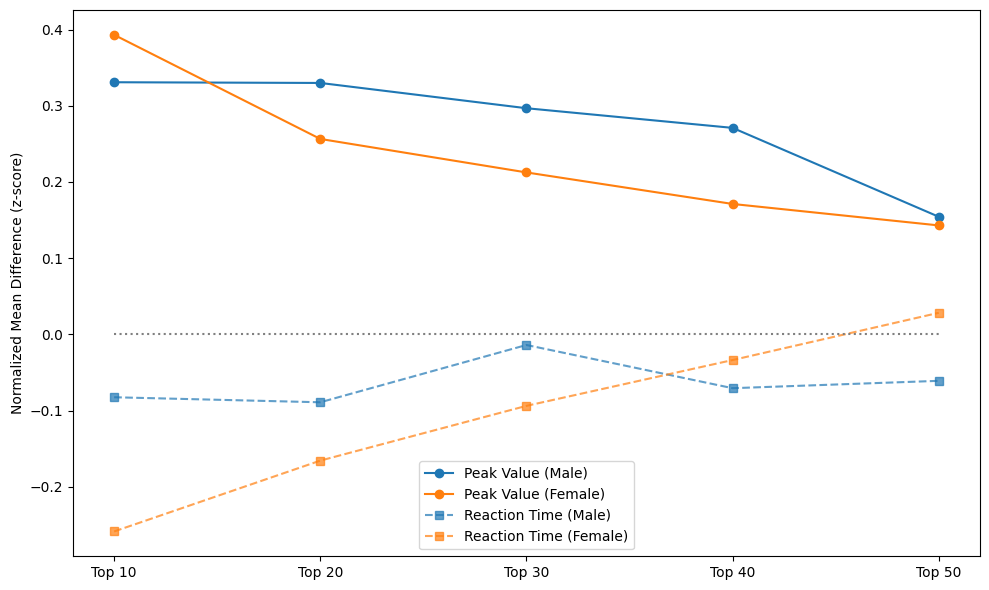

In [15]:
# ...existing code...

import matplotlib.pyplot as plt
import numpy as np

xticks = ['Top 10', 'Top 20', 'Top 30', 'Top 40', 'Top 50']

# Mean differences and stds from your output
peakvalue_means_by_sex = [
    [20.655476, 14.493023],   # Top 10 (male, female)
    [19.729638, 9.344982],    # Top 20
    [18.172272, 7.357317],    # Top 30
    [16.747889, 5.904290],    # Top 40
    [9.874778, 4.909245],     # Top 50
]
peakvalue_stds_by_sex = [
    [62.431973, 36.875188],   # Top 10 (male, female)
    [59.803223, 36.437605],   # Top 20
    [61.234412, 34.614959],   # Top 30
    [61.803132, 34.489655],   # Top 40
    [63.960049, 34.321749],   # Top 50
]

reactiontime_means_by_sex = [
    [-0.152794, -0.530487],   # Top 10 (male, female)
    [-0.155586, -0.330914],   # Top 20
    [-0.025222, -0.183443],   # Top 30
    [-0.128480, -0.063296],   # Top 40
    [-0.118010, 0.052054],    # Top 50
]
reactiontime_stds_by_sex = [
    [1.855569, 2.053325],     # Top 10 (male, female)
    [1.749546, 2.000000],     # Top 20
    [1.829721, 1.959488],     # Top 30
    [1.823701, 1.888092],     # Top 40
    [1.940902, 1.831815],     # Top 50
]

x = np.arange(len(xticks))

# Normalize by standard deviation (z-score)
male_peak_norm = [v[0]/s[0] for v, s in zip(peakvalue_means_by_sex, peakvalue_stds_by_sex)]
female_peak_norm = [v[1]/s[1] for v, s in zip(peakvalue_means_by_sex, peakvalue_stds_by_sex)]
male_rt_norm = [v[0]/s[0] for v, s in zip(reactiontime_means_by_sex, reactiontime_stds_by_sex)]
female_rt_norm = [v[1]/s[1] for v, s in zip(reactiontime_means_by_sex, reactiontime_stds_by_sex)]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x, male_peak_norm, marker='o', label='Peak Value (Male)', color='tab:blue')
ax.plot(x, female_peak_norm, marker='o', label='Peak Value (Female)', color='tab:orange')
ax.plot(x, male_rt_norm, marker='s', linestyle='--', label='Reaction Time (Male)', color='tab:blue', alpha=0.7)
ax.plot(x, female_rt_norm, marker='s', linestyle='--', label='Reaction Time (Female)', color='tab:orange', alpha=0.7)

ax.plot(x, [0]*len(x), linestyle=':', color='gray', alpha=1)

ax.set_xticks(x)
ax.set_xticklabels(xticks)
ax.set_ylabel('Normalized Mean Difference (z-score)')
ax.legend(loc='lower center')
plt.tight_layout()
plt.show()
# ...existing code...

In [16]:
print("Top 10:")
trend_df = compare_general_trends_by_sex(dfs['C10'], dfs['CM10'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['C10'], dfs['CM10'], variables)
print(sig_df)

print("Top 20:")
trend_df = compare_general_trends_by_sex(dfs['C20'], dfs['CM20'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['C20'], dfs['CM20'], variables)
print(sig_df)

print("Top 30:")
trend_df = compare_general_trends_by_sex(dfs['C30'], dfs['CM30'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['C30'], dfs['CM30'], variables)
print(sig_df)

print("Top 40:")
trend_df = compare_general_trends_by_sex(dfs['C40'], dfs['CM40'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['C40'], dfs['CM40'], variables)
print(sig_df)

print("Top 50:")
trend_df = compare_general_trends_by_sex(dfs['C50'], dfs['CM50'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['C50'], dfs['CM50'], variables)
print(sig_df)

Top 10:
       sex      variable  mean_difference  df1_median      df1_std  df1_n  \
0   female  reactionTime         0.002007      10.000     1.933286     78   
1   female      peakTime        -0.501226      30.000     0.625786     78   
2   female    difference        -0.503233      20.000     2.035974     78   
3   female     peakValue         0.654069      90.000    33.587151     78   
4   female          PTPA         0.857858      90.210    33.592686     78   
5   female          PTTA        -0.123467      77.465    30.806279     78   
6   female           RMS         0.661860      37.170    14.536679     78   
7   female           tau         9.107068     163.000    48.099059     78   
8   female           AUC       594.125456   10437.205  4228.139164     78   
9     male  reactionTime        -0.321242      10.000     2.661968     72   
10    male      peakTime         0.703595      30.000     6.170250     72   
11    male    difference         1.024837      20.000     6.801454  

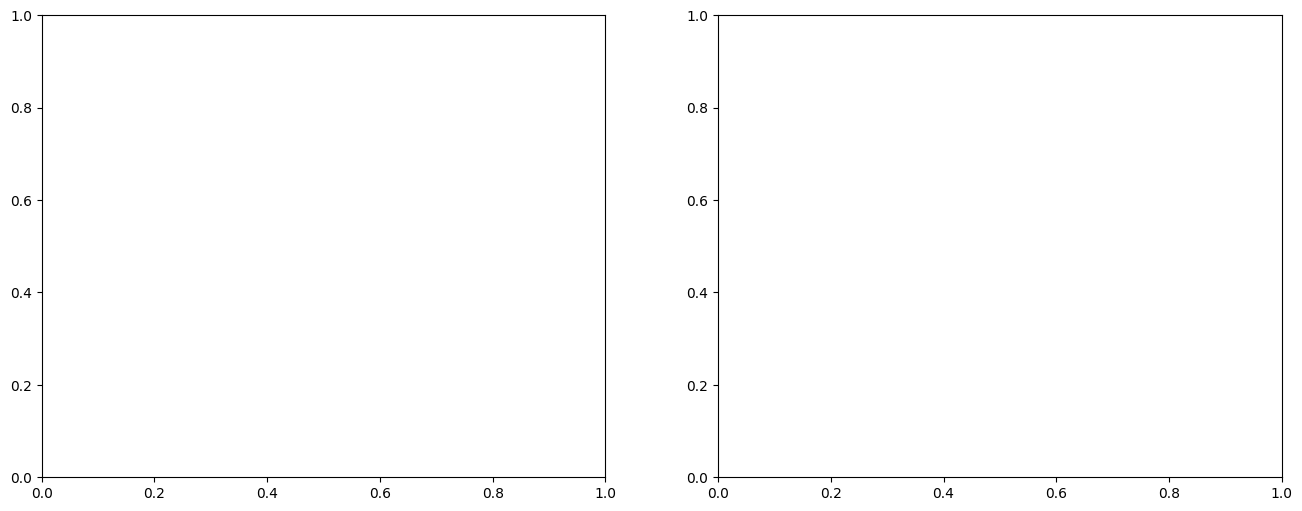

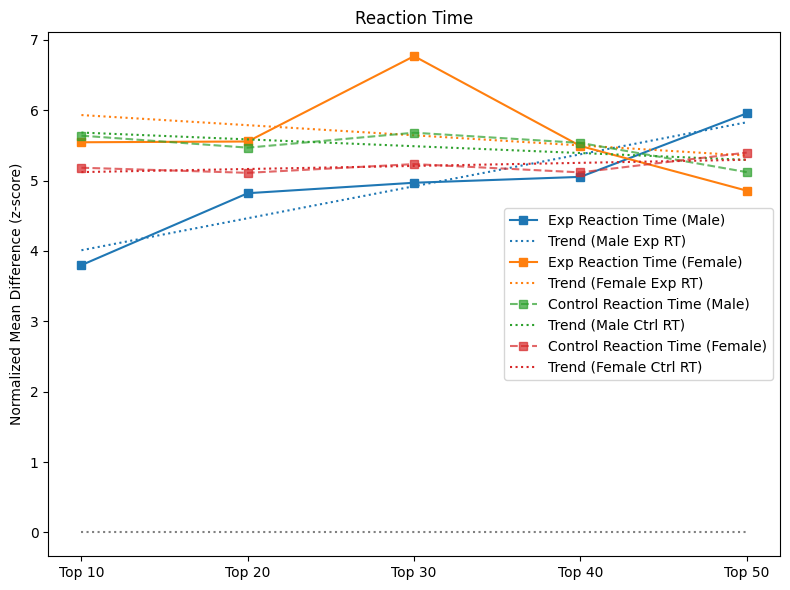

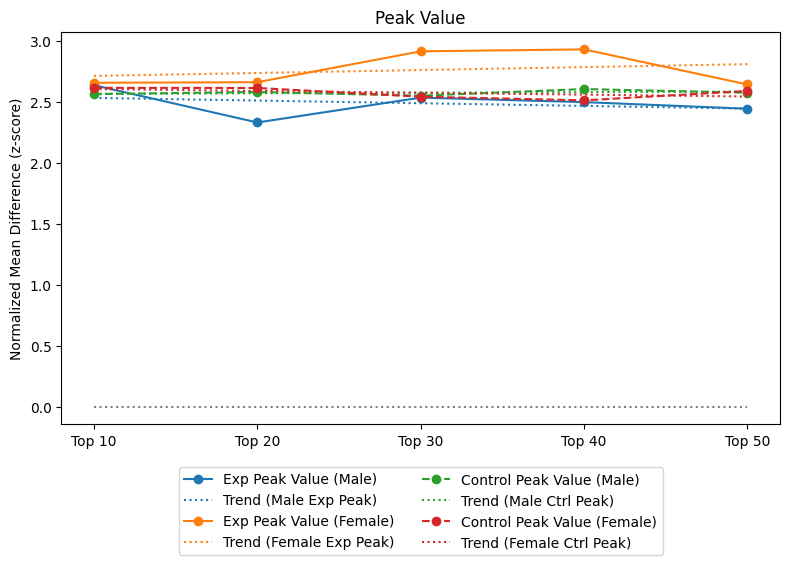

Reaction Time Slopes:
  Male Exp:   0.4545
  Male Ctrl:  -0.0969
  Female Exp: -0.1439
  Female Ctrl:0.0437
Peak Value Slopes:
  Male Exp:   -0.0219
  Male Ctrl:  0.0047
  Female Exp: 0.0241
  Female Ctrl:-0.0153
Peak Value (Male, line): U=5.00, p=0.1508
Peak Value (Female, line): U=25.00, p=0.0079
Reaction Time (Male, line): U=5.00, p=0.1508
Reaction Time (Female, line): U=20.00, p=0.1508


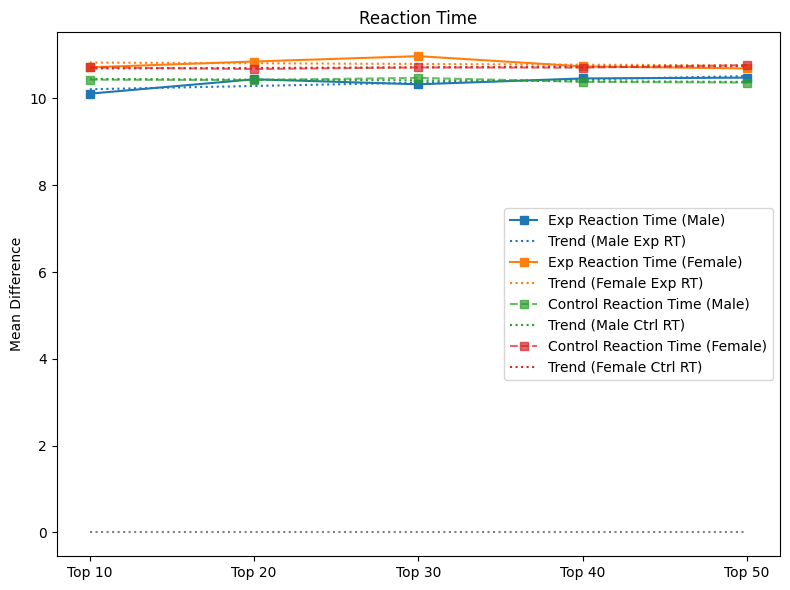

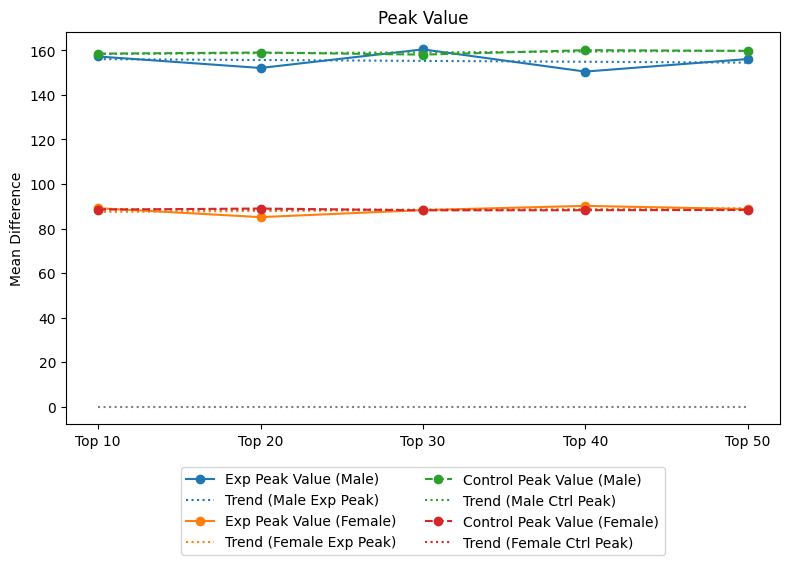

Reaction Time Slopes:
  Male Exp:   0.0758
  Male Ctrl:  -0.0174
  Female Exp: -0.0165
  Female Ctrl:0.0136
Peak Value Slopes:
  Male Exp:   -0.3929
  Male Ctrl:  0.3547
  Female Exp: 0.4253
  Female Ctrl:-0.0995
Peak Value (Male, line): U=5.00, p=0.1508
Peak Value (Female, line): U=16.00, p=0.5476
Reaction Time (Male, line): U=13.00, p=1.0000
Reaction Time (Female, line): U=19.00, p=0.2222


In [17]:
# ...existing code...

def extract_raw_means_stds_by_sex(df, variable):
    # Returns ([male_mean, female_mean], [male_std, female_std]) for a given variable
    sexes = ['male', 'female']
    means = []
    stds = []
    for sex in sexes:
        df_sex = df[df['sex'] == sex]
        flat = flatten_column(df_sex[variable]) if variable in df_sex else pd.Series([])
        means.append(flat.mean() if len(flat) > 0 else np.nan)
        stds.append(flat.std() if len(flat) > 0 else np.nan)
    return means, stds

# Replace extraction in build_sex_lists:
def build_sex_lists(top_keys, control_keys, variables):
    exp_peak_means, exp_peak_stds = [], []
    exp_rt_means, exp_rt_stds = [], []
    ctrl_peak_means, ctrl_peak_stds = [], []
    ctrl_rt_means, ctrl_rt_stds = [], []
    for exp_key, ctrl_key in zip(top_keys, control_keys):
        peak_means, peak_stds = extract_raw_means_stds_by_sex(dfs[exp_key], 'peakValue')
        exp_peak_means.append(peak_means)
        exp_peak_stds.append(peak_stds)
        rt_means, rt_stds = extract_raw_means_stds_by_sex(dfs[exp_key], 'reactionTime')
        exp_rt_means.append(rt_means)
        exp_rt_stds.append(rt_stds)
        peak_means_ctrl, peak_stds_ctrl = extract_raw_means_stds_by_sex(dfs[ctrl_key], 'peakValue')
        ctrl_peak_means.append(peak_means_ctrl)
        ctrl_peak_stds.append(peak_stds_ctrl)
        rt_means_ctrl, rt_stds_ctrl = extract_raw_means_stds_by_sex(dfs[ctrl_key], 'reactionTime')
        ctrl_rt_means.append(rt_means_ctrl)
        ctrl_rt_stds.append(rt_stds_ctrl)
    return exp_peak_means, exp_peak_stds, exp_rt_means, exp_rt_stds, ctrl_peak_means, ctrl_peak_stds, ctrl_rt_means, ctrl_rt_stds

# Define your keys and variables
top_keys = ['C10', 'C20', 'C30', 'C40', 'C50']
control_keys = ['CM10', 'CM20', 'CM30', 'CM40', 'CM50']
variables = ['peakValue', 'reactionTime']

# Build lists dynamically
(peakvalue_means_by_sex, peakvalue_stds_by_sex,
 reactiontime_means_by_sex, reactiontime_stds_by_sex,
 control_peakvalue_means_by_sex, control_peakvalue_stds_by_sex,
 control_reactiontime_means_by_sex, control_reactiontime_stds_by_sex) = build_sex_lists(top_keys, control_keys, variables)

xticks = ['Top 10', 'Top 20', 'Top 30', 'Top 40', 'Top 50']
x = np.arange(len(xticks))

# Normalize by standard deviation (z-score)
male_peak_norm = [v[0]/s[0] for v, s in zip(peakvalue_means_by_sex, peakvalue_stds_by_sex)]
female_peak_norm = [v[1]/s[1] for v, s in zip(peakvalue_means_by_sex, peakvalue_stds_by_sex)]
male_rt_norm = [v[0]/s[0] for v, s in zip(reactiontime_means_by_sex, reactiontime_stds_by_sex)]
female_rt_norm = [v[1]/s[1] for v, s in zip(reactiontime_means_by_sex, reactiontime_stds_by_sex)]

male_peak_control_norm = [v[0]/s[0] for v, s in zip(control_peakvalue_means_by_sex, control_peakvalue_stds_by_sex)]
female_peak_control_norm = [v[1]/s[1] for v, s in zip(control_peakvalue_means_by_sex, control_peakvalue_stds_by_sex)]
male_rt_control_norm = [v[0]/s[0] for v, s in zip(control_reactiontime_means_by_sex, control_reactiontime_stds_by_sex)]
female_rt_control_norm = [v[1]/s[1] for v, s in zip(control_reactiontime_means_by_sex, control_reactiontime_stds_by_sex)]

# ...existing code...
# ...existing code...

def plot_trendline(ax, x, y, color, linestyle, label):
    coeffs = np.polyfit(x, y, 1)
    trend = np.polyval(coeffs, x)
    ax.plot(x, trend, color=color, linestyle=linestyle, alpha=1, label=label)
    return coeffs[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))


# --- Reaction Time Plot ---
fig_rt, ax_rt = plt.subplots(figsize=(8, 6))
ax_rt.plot(x, male_rt_norm, marker='s', linestyle='-', label='Exp Reaction Time (Male)', color='tab:blue')
plot_trendline(ax_rt, x, male_rt_norm, color='tab:blue', linestyle=':', label='Trend (Male Exp RT)')
ax_rt.plot(x, female_rt_norm, marker='s', linestyle='-', label='Exp Reaction Time (Female)', color='tab:orange')
plot_trendline(ax_rt, x, female_rt_norm, color='tab:orange', linestyle=':', label='Trend (Female Exp RT)')
ax_rt.plot(x, male_rt_control_norm, marker='s', linestyle='--', label='Control Reaction Time (Male)', color='tab:green', alpha=0.7)
plot_trendline(ax_rt, x, male_rt_control_norm, color='tab:green', linestyle=':', label='Trend (Male Ctrl RT)')
ax_rt.plot(x, female_rt_control_norm, marker='s', linestyle='--', label='Control Reaction Time (Female)', color='tab:red', alpha=0.7)
plot_trendline(ax_rt, x, female_rt_control_norm, color='tab:red', linestyle=':', label='Trend (Female Ctrl RT)')
ax_rt.plot(x, [0]*len(x), linestyle=':', color='gray', alpha=1)
ax_rt.set_xticks(x)
ax_rt.set_xticklabels(xticks)
ax_rt.set_ylabel('Normalized Mean Difference (z-score)')
ax_rt.set_title('Reaction Time')
ax_rt.legend()#loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=2)
plt.tight_layout()
plt.show()

# --- Peak Value Plot ---
fig_peak, ax_peak = plt.subplots(figsize=(8, 6))
ax_peak.plot(x, male_peak_norm, marker='o', linestyle='-', label='Exp Peak Value (Male)', color='tab:blue')
plot_trendline(ax_peak, x, male_peak_norm, color='tab:blue', linestyle=':', label='Trend (Male Exp Peak)')
ax_peak.plot(x, female_peak_norm, marker='o', linestyle='-', label='Exp Peak Value (Female)', color='tab:orange')
plot_trendline(ax_peak, x, female_peak_norm, color='tab:orange', linestyle=':', label='Trend (Female Exp Peak)')
ax_peak.plot(x, male_peak_control_norm, marker='o', linestyle='--', label='Control Peak Value (Male)', color='tab:green')
plot_trendline(ax_peak, x, male_peak_control_norm, color='tab:green', linestyle=':', label='Trend (Male Ctrl Peak)')
ax_peak.plot(x, female_peak_control_norm, marker='o', linestyle='--', label='Control Peak Value (Female)', color='tab:red')
plot_trendline(ax_peak, x, female_peak_control_norm, color='tab:red', linestyle=':', label='Trend (Female Ctrl Peak)')
ax_peak.plot(x, [0]*len(x), linestyle=':', color='gray', alpha=1)
ax_peak.set_xticks(x)
ax_peak.set_xticklabels(xticks)
ax_peak.set_ylabel('Normalized Mean Difference (z-score)')
ax_peak.set_title('Peak Value')
ax_peak.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=2)
plt.tight_layout()
plt.show()
# ...existing code..
# 

from scipy.stats import mannwhitneyu

def get_slope(x, y):
    coeffs = np.polyfit(x, y, 1)
    return coeffs[0]

# Calculate slopes for each group
male_exp_rt_slope = get_slope(x, male_rt_norm)
female_exp_rt_slope = get_slope(x, female_rt_norm)
male_ctrl_rt_slope = get_slope(x, male_rt_control_norm)
female_ctrl_rt_slope = get_slope(x, female_rt_control_norm)

male_exp_peak_slope = get_slope(x, male_peak_norm)
female_exp_peak_slope = get_slope(x, female_peak_norm)
male_ctrl_peak_slope = get_slope(x, male_peak_control_norm)
female_ctrl_peak_slope = get_slope(x, female_peak_control_norm)

print("Reaction Time Slopes:")
print(f"  Male Exp:   {male_exp_rt_slope:.4f}")
print(f"  Male Ctrl:  {male_ctrl_rt_slope:.4f}")
print(f"  Female Exp: {female_exp_rt_slope:.4f}")
print(f"  Female Ctrl:{female_ctrl_rt_slope:.4f}")

print("Peak Value Slopes:")
print(f"  Male Exp:   {male_exp_peak_slope:.4f}")
print(f"  Male Ctrl:  {male_ctrl_peak_slope:.4f}")
print(f"  Female Exp: {female_exp_peak_slope:.4f}")
print(f"  Female Ctrl:{female_ctrl_peak_slope:.4f}")

def print_line_diff_test_nonparametric(exp, ctrl, label):
    stat, p = mannwhitneyu(exp, ctrl, alternative='two-sided')
    print(f"{label}: U={stat:.2f}, p={p:.4f}")

print_line_diff_test_nonparametric(male_peak_norm, male_peak_control_norm, "Peak Value (Male, line)")
print_line_diff_test_nonparametric(female_peak_norm, female_peak_control_norm, "Peak Value (Female, line)")
print_line_diff_test_nonparametric(male_rt_norm, male_rt_control_norm, "Reaction Time (Male, line)")
print_line_diff_test_nonparametric(female_rt_norm, female_rt_control_norm, "Reaction Time (Female, line)")





# ...existing code...

# Use raw mean differences instead of normalized values
male_peak_means = [v[0] for v in peakvalue_means_by_sex]
female_peak_means = [v[1] for v in peakvalue_means_by_sex]
male_rt_means = [v[0] for v in reactiontime_means_by_sex]
female_rt_means = [v[1] for v in reactiontime_means_by_sex]

male_peak_control_means = [v[0] for v in control_peakvalue_means_by_sex]
female_peak_control_means = [v[1] for v in control_peakvalue_means_by_sex]
male_rt_control_means = [v[0] for v in control_reactiontime_means_by_sex]
female_rt_control_means = [v[1] for v in control_reactiontime_means_by_sex]

# --- Reaction Time Plot ---
fig_rt, ax_rt = plt.subplots(figsize=(8, 6))
ax_rt.plot(x, male_rt_means, marker='s', linestyle='-', label='Exp Reaction Time (Male)', color='tab:blue')
plot_trendline(ax_rt, x, male_rt_means, color='tab:blue', linestyle=':', label='Trend (Male Exp RT)')
ax_rt.plot(x, female_rt_means, marker='s', linestyle='-', label='Exp Reaction Time (Female)', color='tab:orange')
plot_trendline(ax_rt, x, female_rt_means, color='tab:orange', linestyle=':', label='Trend (Female Exp RT)')
ax_rt.plot(x, male_rt_control_means, marker='s', linestyle='--', label='Control Reaction Time (Male)', color='tab:green', alpha=0.7)
plot_trendline(ax_rt, x, male_rt_control_means, color='tab:green', linestyle=':', label='Trend (Male Ctrl RT)')
ax_rt.plot(x, female_rt_control_means, marker='s', linestyle='--', label='Control Reaction Time (Female)', color='tab:red', alpha=0.7)
plot_trendline(ax_rt, x, female_rt_control_means, color='tab:red', linestyle=':', label='Trend (Female Ctrl RT)')
ax_rt.plot(x, [0]*len(x), linestyle=':', color='gray', alpha=1)
ax_rt.set_xticks(x)
ax_rt.set_xticklabels(xticks)
ax_rt.set_ylabel('Mean Difference')
ax_rt.set_title('Reaction Time')
ax_rt.legend()
plt.tight_layout()
plt.show()

# --- Peak Value Plot ---
fig_peak, ax_peak = plt.subplots(figsize=(8, 6))
ax_peak.plot(x, male_peak_means, marker='o', linestyle='-', label='Exp Peak Value (Male)', color='tab:blue')
plot_trendline(ax_peak, x, male_peak_means, color='tab:blue', linestyle=':', label='Trend (Male Exp Peak)')
ax_peak.plot(x, female_peak_means, marker='o', linestyle='-', label='Exp Peak Value (Female)', color='tab:orange')
plot_trendline(ax_peak, x, female_peak_means, color='tab:orange', linestyle=':', label='Trend (Female Exp Peak)')
ax_peak.plot(x, male_peak_control_means, marker='o', linestyle='--', label='Control Peak Value (Male)', color='tab:green')
plot_trendline(ax_peak, x, male_peak_control_means, color='tab:green', linestyle=':', label='Trend (Male Ctrl Peak)')
ax_peak.plot(x, female_peak_control_means, marker='o', linestyle='--', label='Control Peak Value (Female)', color='tab:red')
plot_trendline(ax_peak, x, female_peak_control_means, color='tab:red', linestyle=':', label='Trend (Female Ctrl Peak)')
ax_peak.plot(x, [0]*len(x), linestyle=':', color='gray', alpha=1)
ax_peak.set_xticks(x)
ax_peak.set_xticklabels(xticks)
ax_peak.set_ylabel('Mean Difference')
ax_peak.set_title('Peak Value')
ax_peak.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=2)
plt.tight_layout()
plt.show()

# Calculate slopes for each group (raw means)
male_exp_rt_slope = get_slope(x, male_rt_means)
female_exp_rt_slope = get_slope(x, female_rt_means)
male_ctrl_rt_slope = get_slope(x, male_rt_control_means)
female_ctrl_rt_slope = get_slope(x, female_rt_control_means)

male_exp_peak_slope = get_slope(x, male_peak_means)
female_exp_peak_slope = get_slope(x, female_peak_means)
male_ctrl_peak_slope = get_slope(x, male_peak_control_means)
female_ctrl_peak_slope = get_slope(x, female_peak_control_means)

print("Reaction Time Slopes:")
print(f"  Male Exp:   {male_exp_rt_slope:.4f}")
print(f"  Male Ctrl:  {male_ctrl_rt_slope:.4f}")
print(f"  Female Exp: {female_exp_rt_slope:.4f}")
print(f"  Female Ctrl:{female_ctrl_rt_slope:.4f}")

print("Peak Value Slopes:")
print(f"  Male Exp:   {male_exp_peak_slope:.4f}")
print(f"  Male Ctrl:  {male_ctrl_peak_slope:.4f}")
print(f"  Female Exp: {female_exp_peak_slope:.4f}")
print(f"  Female Ctrl:{female_ctrl_peak_slope:.4f}")

def print_line_diff_test_nonparametric(exp, ctrl, label):
    stat, p = mannwhitneyu(exp, ctrl, alternative='two-sided')
    print(f"{label}: U={stat:.2f}, p={p:.4f}")

print_line_diff_test_nonparametric(male_peak_means, male_peak_control_means, "Peak Value (Male, line)")
print_line_diff_test_nonparametric(female_peak_means, female_peak_control_means, "Peak Value (Female, line)")
print_line_diff_test_nonparametric(male_rt_means, male_rt_control_means, "Reaction Time (Male, line)")
print_line_diff_test_nonparametric(female_rt_means, female_rt_control_means, "Reaction Time (Female, line)")

# ...existing code...
